In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, models
import torchvision.utils as vutils
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:

DATASET_TRAIN = os.path.join('/content/drive/MyDrive/archive', 'real_and_fake_face')
INITIAL_SIZE_OF_IMAGES = (128, 128)
DATASET_TEST = os.path.join('/content/drive/MyDrive/archive', 'real_and_fake_face_detection')

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# Configurar transformaciones para las imágenes CNN para adaptarlas a Resnet18
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

full_train_dataset = datasets.ImageFolder(root=DATASET_TRAIN, transform=transforms)

test_dataset = datasets.ImageFolder(root=DATASET_TEST, transform=transforms)

# Dividir el conjunto de entrenamiento en entrenamiento y validación

train_size = int(0.9 * len(full_train_dataset)) # 90% para entrenamiento
valid_size = len(full_train_dataset) - train_size # 10% para validación
train_dataset, valid_dataset = torch.utils.data.random_split (full_train_dataset, [train_size, valid_size])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# FINE TUNING

# Fine Tuning Tipo I


In [5]:
# Cargar el modelo preentrenado resnet18
resnet18 = models.resnet18(pretrained=True)

# Descongelar algunas de las últimas capas convolucionales
for param in resnet18.parameters():
    param.requires_grad = False

# Descongelar las últimas cinco capas
for param in resnet18.layer4.parameters():
    param.requires_grad = True

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 66.7MB/s]


In [6]:
# Cambiar las capas del clasificador
num_classes = 2  # Reemplazar con el número de clases en tu conjunto de datos
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)


In [7]:
# Mover el modelo al dispositivo disponible (GPU o CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.fc.parameters(), lr=0.001)

In [8]:
# Función para entrenar el modelo
def train_model_func(model, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()  # Poner el modelo en modo entrenamiento
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_dataset)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    print('Training complete')

# Función para evaluar la precisión del modelo
def evaluate_model(model, data_loader):
    model.eval()  # Poner el modelo en modo evaluación
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

In [9]:
# Entrenar
#train_model_func(resnet18, criterion, optimizer, num_epochs=5)

In [10]:
# Evaluar el modelo
#evaluate_model(resnet18, test_loader)

# CNN

In [11]:
data_transforms = transforms.Compose([
    transforms.Resize(INITIAL_SIZE_OF_IMAGES),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0,0,0),std=(1/255.0, 1/255.0, 1/255.0)), #Normalización
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=(-0.2, 0.2)),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    #transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
])

full_train_dataset = datasets.ImageFolder(root=DATASET_TRAIN, transform=data_transforms)

test_dataset = datasets.ImageFolder(root=DATASET_TEST, transform=data_transforms)

# Dividir el conjunto de entrenamiento en entrenamiento y validación

train_size = int(0.9 * len(full_train_dataset)) # 90% para entrenamiento
valid_size = len(full_train_dataset) - train_size # 10% para validación
train_dataset, valid_dataset = torch.utils.data.random_split (full_train_dataset, [train_size, valid_size])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)



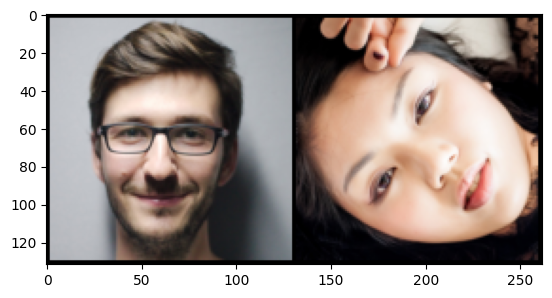

In [12]:
# Obtiene un batch de imagenes
dataiter = iter(train_loader)
images, labels = dataiter._next_data()
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Mostramos las imagenes
imshow(vutils.make_grid(images[1:3], normalize=True))

In [13]:
class FaceDetection_CNN(nn.Module):
    def __init__(self):
        super(FaceDetection_CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64*32*32, 128)

        self.fc2 = nn.Linear(128, 2)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        #x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        #x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1,64*32*32)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [14]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0


In [15]:
early_stopping = EarlyStopping(patience=5)

In [16]:

# Crear una instancia de la red
model = FaceDetection_CNN().to(device)
print(model)
#criterion = nn.BCELoss().to(device) # incluye activacion sigmoid
criterion = nn.CrossEntropyLoss().to(device) # no se usa activación, incluye softmax internamente
optimizer = optim.Adam(model.parameters(),  lr=0.0001, weight_decay=0.001)

FaceDetection_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [17]:
num_epochs = 10
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    training_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        training_loss += loss.item()

        _, predicted = torch.max(outputs.data,1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    avg_train_loss = training_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)
    valid_accuracy = 100 * correct_valid / total_valid
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%')
    early_stopping(avg_valid_loss)

    if early_stopping.early_stop:
        print("Deteniendo el entrenamiento, modelo entrenado con early stopping.")
        break
    #wandb.log({"epoch":epoch+1/num_epochs,"Train Loss":avg_train_loss,"Train Acc":train_accuracy,"Valid Loss":avg_valid_loss,"Valid Acc":valid_accuracy})
    model.train()

print("Entrenamiento finalizado!")

Epoch [1/10], Train Loss: 0.8706, Train Acc: 50.82%, Valid Loss: 0.6882, Valid Acc: 56.59%
Epoch [2/10], Train Loss: 0.6859, Train Acc: 53.92%, Valid Loss: 0.6786, Valid Acc: 58.54%
Epoch [3/10], Train Loss: 0.6756, Train Acc: 56.97%, Valid Loss: 0.6823, Valid Acc: 57.07%
Epoch [4/10], Train Loss: 0.6781, Train Acc: 56.64%, Valid Loss: 0.6785, Valid Acc: 56.10%
Epoch [5/10], Train Loss: 0.6699, Train Acc: 58.06%, Valid Loss: 0.6732, Valid Acc: 60.98%
Epoch [6/10], Train Loss: 0.6680, Train Acc: 58.33%, Valid Loss: 0.6770, Valid Acc: 61.95%
Epoch [7/10], Train Loss: 0.6681, Train Acc: 59.10%, Valid Loss: 0.6730, Valid Acc: 60.49%
Epoch [8/10], Train Loss: 0.6674, Train Acc: 57.73%, Valid Loss: 0.6698, Valid Acc: 55.61%
Epoch [9/10], Train Loss: 0.6605, Train Acc: 58.93%, Valid Loss: 0.6627, Valid Acc: 62.93%
Epoch [10/10], Train Loss: 0.6544, Train Acc: 60.62%, Valid Loss: 0.6586, Valid Acc: 61.95%
Entrenamiento finalizado!


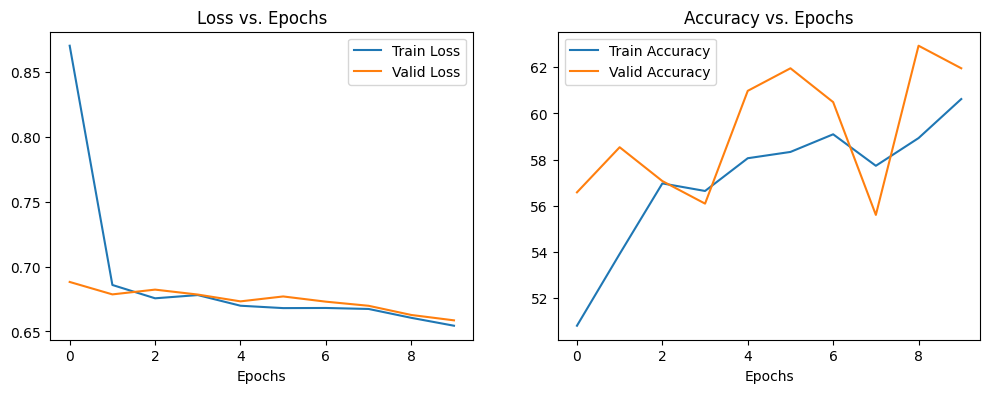

In [18]:
# Graficar el accuracy y el loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.legend()
plt.xlabel('Epochs')
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.title('Accuracy vs. Epochs')

plt.show()

In [19]:
X_train.type()

NameError: name 'X_train' is not defined

In [ ]:
train_accuracies = []
val_accuracies = []

X_train_tensor = torch.tensor(train_dataset, dtype=torch.float32)
Y_train_tensor = torch.tensor(valid_dataset, dtype=torch.float32)

percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for percentage in percentages:

    subset_size = int(len(X_train_tensor) * percentage)
    subset_indices = torch.randperm(len(X_train_tensor))[:subset_size]

    X_train_subset = X_train_tensor[subset_indices]
    Y_train_subset = Y_train_tensor[subset_indices]

    model.train()
    for epoch in range(5):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        train_preds = (model(X_train_subset) > 0).float()
        train_accuracy = (train_preds == Y_train_subset).float().mean().item()
        train_accuracies.append(train_accuracy)

    with torch.no_grad():
        val_preds = (model(valid_loader) > 0).float()
        val_accuracy = (val_preds == valid_loader).float().mean().item()
        val_accuracies.append(val_accuracy)

# Graficar la evolución del accuracy
plt.plot(percentages, train_accuracies, label='Train Accuracy')
plt.plot(percentages, val_accuracies, label='Validation Accuracy')
plt.xlabel('Percentage of Data Used')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        # pasar al dispositivo
        images = images.to(device)
        labels = labels.to(device)
        ############################
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Precisión del modelo en las imágenes de prueba: {100 * correct / total}%')